# Image classification with a CNN
In this exercise you must design a CNN to classify a dataset loaded from a csv file.
Use data normalisation, data augmentation and steps to avoid overfiting to improve you fitting accuracy.


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

torch.manual_seed(99)
np.random.seed(99)



In [11]:
classes = ['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

file_path = 'FMNIST.csv'
data_df = pd.read_csv(file_path)
data_df.head()

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
train_df,test_df = train_test_split(data_df,test_size=0.5)

train_data = torch.tensor(train_df.iloc[:, 1:].to_numpy(dtype = 'float32')/255)
test_data = torch.tensor(test_df.iloc[:, 1:].to_numpy(dtype = 'float32')/255)
train_labels = torch.tensor(train_df['label'].values).long()
test_labels = torch.tensor(test_df['label'].values).long()
test_data.shape

torch.Size([5000, 784])

Reshape the pixel data to create 2D images (28x28 pixels) for both the training and test data. Store the results of the reshaping of the train_data as train_images and test_data as test_images

Plot a sample of 16 images from the test dataset, each with axis title corresponding to the classes from which it belongs

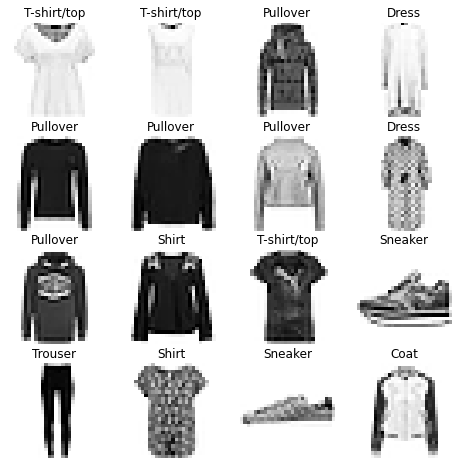

In [13]:
train_images = train_data.reshape(-1,1,28,28)
test_images = test_data.reshape(-1,1,28,28)


fig,axs = plt.subplots(4,4,figsize=(8,8))
axs = axs.flatten()
for n,ax in enumerate(axs):
    ax.imshow(test_images[n][0],cmap="Greys")
    ax.set_title(classes[test_labels[n]])
    ax.axis('off')

Create pytorch Dataset objects for you labels and images (hint TensorDataset) and DataLoaders for the training and test datasets using a suitable batch size for the data loaders

In [14]:

train_dataset = TensorDataset(train_labels,train_images)
test_dataset = TensorDataset(test_labels,test_images,)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size,shuffle=False )


In the following cell, define a convolutional neural network to classify the  dataset, including elements to reduce overfitting.

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),  # b, 16, 10, 10
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(2),  # b, 16, 5, 5
            nn.Dropout(0.4),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),  # b, 8, 3, 3
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(2),  # b, 16, 5, 5
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(784, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.Linear(200, num_classes),
            )
        

    def forward(self, x):
        out = self.cnn(x)
      
        return out

Write a function for training a classification neural network, which takes four inputs: the model, the training data loader, the test data loader and the number of epochs. The function should iterate through the training data and at the end of each epoch it should print out the training loss function, the test loss function and the test accuracy of classification

In [ ]:

num_epochs = 5
n_pixels = 28*28
num_classes = 10

def train(model,train_loader,test_loader,num_epochs,optimizer):
    criterion = nn.CrossEntropyLoss()
    
    epochs, epoch_loss, epoch_val_loss, epoch_accuracy= [],[],[],[]
    for n in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx,(labels, data) in enumerate(train_loader):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
        train_loss = train_loss/(batch_idx+1)
        epoch_loss.append(train_loss)
        model.eval()  
        correct = 0
        total = 0
        loss_list = []
        with torch.no_grad():
            for batch_idx,(labels, data) in enumerate(test_loader):
                outputs = model(data)
                loss = criterion(outputs, labels)
                loss_list.append(loss)
                correct += (outputs.argmax(1) == labels).sum().item()
                total += len(labels)
                
        val_loss = np.mean(loss_list)
        epoch_val_loss.append(val_loss)
        accuracy = correct/total  
        epoch_accuracy.append(accuracy*100)
        epochs.append(n+1)
        print(f'{n+1} / {num_epochs}: loss {train_loss:0.03f}, val_loss {val_loss:0.03f}, accuracy {accuracy:0.03f}')
        
    fig,axs = plt.subplots(1,2,figsize=(16,5))
    axs[0].plot(epochs,epoch_loss,label='train')
    axs[0].plot(epochs,epoch_val_loss,label='val')
    axs[0].legend()
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[1].plot(epochs,epoch_accuracy)
    axs[1].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')



Train your model for 50 epochs


1 / 50: loss 1.118, val_loss 0.849, accuracy 0.743
2 / 50: loss 0.648, val_loss 0.568, accuracy 0.798
3 / 50: loss 0.564, val_loss 0.528, accuracy 0.807
4 / 50: loss 0.521, val_loss 0.464, accuracy 0.836
5 / 50: loss 0.497, val_loss 0.442, accuracy 0.839
6 / 50: loss 0.470, val_loss 0.448, accuracy 0.835
7 / 50: loss 0.453, val_loss 0.413, accuracy 0.854
8 / 50: loss 0.450, val_loss 0.403, accuracy 0.852
9 / 50: loss 0.417, val_loss 0.401, accuracy 0.856
10 / 50: loss 0.411, val_loss 0.409, accuracy 0.851
11 / 50: loss 0.410, val_loss 0.379, accuracy 0.866
12 / 50: loss 0.392, val_loss 0.381, accuracy 0.862
13 / 50: loss 0.382, val_loss 0.371, accuracy 0.869
14 / 50: loss 0.375, val_loss 0.373, accuracy 0.869
15 / 50: loss 0.370, val_loss 0.355, accuracy 0.874
16 / 50: loss 0.361, val_loss 0.356, accuracy 0.871
17 / 50: loss 0.355, val_loss 0.350, accuracy 0.875
18 / 50: loss 0.350, val_loss 0.354, accuracy 0.872
19 / 50: loss 0.341, val_loss 0.345, accuracy 0.874
20 / 50: loss 0.343, 

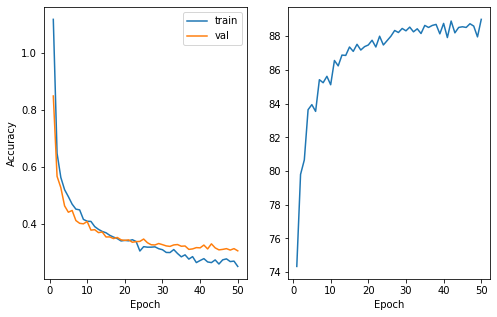

In [29]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-3)
train(model,train_loader,test_loader,50,optimizer)



Comment on the performance of your network, do you observe underfitting or overfitting? What other steps could you take to improve the test accuracy of your model?

#### Answer in this markdown cell:
The training loss is steadily decreasing with each epoch and has not yet saturated, indicating that there is still some underfitting. The validation loss seems to saturate and is slightly worse than the training loss at the end, indicating there is also some overfitting. But the steps included to reduce overfitting seem to be working quite well as the difference is not too large.

To increase the accuracy furter we would increase the size of the training dataset or use data augmentation to increase its variability. Also, we could increase the dropout fraction or weight_decay to try and further reduce overfitting. We could also try to reduce the complexity of the model to see if we can still get a good fit to the training data, while improving the test accuracy.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

import torchtext
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn
import torch.optim as optim
from torch.nn.functional import pad
from torchtext.data.utils import get_tokenizer


glove = torch.load('glove6V_100_40000.pth')
n_dim = glove.dim
tokenizer = get_tokenizer('basic_english')



In [2]:
torch.manual_seed(99)
np.random.seed(99)

review_df = pd.read_csv("imdb_review_sentiment.tsv",sep='\t',header=0)
review_df = review_df.drop(['id'], axis=1)

num_classes = 2
train_df,test_df = train_test_split(review_df,train_size=0.1,test_size=0.1)
print(len(train_df))
print(len(test_df))
train_df.head()

2500
2500


,sentiment,review
16094,0,I just watched the 30th Anniversary edition of...
3508,1,Spoilers! Classic 70's sex trash! The Swedish ...
11875,1,"On the surface, this is an above-average post-..."
10768,0,"Wow, after trashing the disk of Timo Roses \Ro..."
11566,0,"I don't know what some of you are smoking, but..."


In [3]:
np.median([len(tokenizer(s)) for s in train_df['review']])

201.0

In [4]:
train_labels = torch.tensor(train_df['sentiment'].values).long()
train_texts = train_df['review'].values
test_labels = torch.tensor(test_df['sentiment'].values).long()
test_texts = test_df['review'].values
vec_length = 100

def text_2_inds(text):
    tokens = tokenizer(text)
    # get indices of each token
    inds = [glove.stoi[w] for w in tokens if w in glove.stoi]
    if len(inds)>0:
        inds = torch.tensor(inds)  # turn the indices into a tensor
        # pad to make the tensor at least long enough and then truncate down to size
        inds = pad(inds,(0,vec_length), mode='constant', value=-1.0)[:vec_length]
        return inds


def process_texts(texts):
    text_inds = torch.zeros(len(texts),vec_length).long()
    for n,text in enumerate(texts):
        inds = text_2_inds(text)
        if inds is not None:
            text_inds[n,:] = inds
    return text_inds

test_inds = process_texts(test_texts)
train_inds = process_texts(train_texts)

train_inds.shape

torch.Size([2500, 100])

## Make training and test datasets and dataloaders to for the labels and indices of the reviews
The reviews have a label 0 for negative reviews and 1 for positive reviews. The text has been converted to indices already using a preloaded GloVe model.

In [5]:
batch_size = 64
test_dataset = TensorDataset(test_labels, test_inds)
train_dataset = TensorDataset(train_labels, train_inds)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [6]:
glove.vectors.shape

torch.Size([40000, 100])

## Write a GRU to predict the sentiment of reviews. Include some steps to try and reduce overfitting

In [7]:
class TextMultiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes,mode='RNN'):
        super(TextMultiRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.mode = mode
        self.emb = nn.Embedding.from_pretrained(glove.vectors)

        if mode.lower() in 'ltsm':
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        elif mode.lower() in 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        
        else: 
            if mode.lower() not in 'rnn':
                print('Mode not recognised, using vanilla RNN')
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)        
        
        fc_hidden_size = 50
        self.fc  = nn.Sequential(nn.Linear(hidden_size, fc_hidden_size),
                                 nn.Dropout(0.2),
                                 nn.LeakyReLU(0.2,True),
                                 nn.Linear(fc_hidden_size, num_classes)
                                )
    
    def forward(self, x):

        # Find the index of the last non-zero input
        ind_max,_ = ((x>=0)*torch.arange(x.shape[1]).unsqueeze(0)).max(dim=1)
        # Apply the embedding
        x = self.emb(x.clip(min=0))

        #  Forward propagate through the rnn
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        
        # Forward propagate the rnn layer
        if self.mode.lower() in 'ltsm':
            out, _ = self.rnn(x, (h0,c0))
        else:
            out, _ = self.rnn(x, h0)
            
        # And through the fc layers to the output
        logits = self.fc(out[torch.arange(out.shape[0]),ind_max,:])
        return logits


    

## Define a loss function and optimizer and optimise your model on the training data

In [8]:

def train_network(model, train_loader, val_loader, num_epochs, optimizer):
    criterion = nn.CrossEntropyLoss()
    
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        model.train()
        for labels,texts in train_loader:
            optimizer.zero_grad()
            pred = model(texts)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            
        losses.append(float(loss))     

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, val_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
            epoch+1, loss, train_acc[-1], valid_acc[-1]))

    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for labels,texts in data_loader:
            output = model(texts)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += labels.shape[0]
    return correct / total

Epoch 1; Loss 0.633524; Train Acc 0.553200; Val Acc 0.516800
Epoch 2; Loss 0.774526; Train Acc 0.590800; Val Acc 0.546000
Epoch 3; Loss 0.598734; Train Acc 0.610000; Val Acc 0.559200
Epoch 4; Loss 0.975910; Train Acc 0.596400; Val Acc 0.562400
Epoch 5; Loss 0.424105; Train Acc 0.600400; Val Acc 0.602000
Epoch 6; Loss 0.744258; Train Acc 0.718800; Val Acc 0.708400
Epoch 7; Loss 0.688685; Train Acc 0.760000; Val Acc 0.732800
Epoch 8; Loss 0.304006; Train Acc 0.741600; Val Acc 0.709600
Epoch 9; Loss 0.798953; Train Acc 0.705200; Val Acc 0.676400
Epoch 10; Loss 0.763328; Train Acc 0.758000; Val Acc 0.719600
Epoch 11; Loss 0.208993; Train Acc 0.783600; Val Acc 0.742800
Epoch 12; Loss 0.412202; Train Acc 0.775200; Val Acc 0.743200
Epoch 13; Loss 0.512853; Train Acc 0.818000; Val Acc 0.755200
Epoch 14; Loss 0.249902; Train Acc 0.835600; Val Acc 0.764000
Epoch 15; Loss 0.586923; Train Acc 0.847600; Val Acc 0.763200
Epoch 16; Loss 0.221826; Train Acc 0.847200; Val Acc 0.770800
Epoch 17; Loss 0.

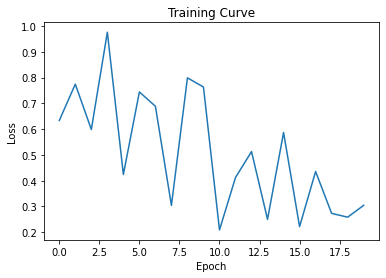

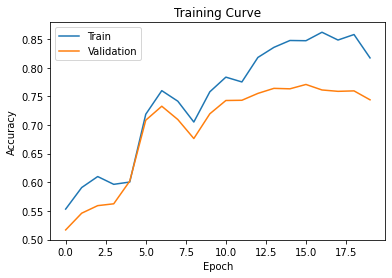

In [9]:
model_gru = TextMultiRNN(n_dim, 50, num_classes,mode='gru')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=1e-3,weight_decay=1e-3)
train_network(model_gru, train_dataloader, test_dataloader,20,optimizer)



### Comment on the performance of your model
Do you suffer underfitting or overfitting? How might you overcome these issues? Also how would you expect this model to perform compared to a standard RNN model.

In [10]:
model_total_params = sum(p.numel() for p in model_gru.parameters())
print(model_total_params)

4025452


The model seems to be suffering both underfitting and overfitting. It would be possible to improve the fitting performance by increasing the model size and reducing the dropout and weight_decay terms. This would most likely make the overfitting worse. To reduce the overfitting it would be best to increase the size of the training data and perhaps include additional dropout, or batch normalisation layers.

# Anomoly detection using autoencoders

In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd

## The following cell loads fashion MNIST datasets and dataloaders

You will use this data to train an autoencoder and check its performance using the validation dataset

In [1]:
torch.manual_seed(0)
np.random.seed(0)

train_dataset = datasets.FashionMNIST('files/', train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                             ]))
val_dataset = datasets.FashionMNIST('files/', train=False, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                             ]))
batch_size = 64


print(len(train_dataset))

# use the train test split to only use 10% of the data
# the underscore _ is used just to dump outputs we don't want into a variable we'll never use
_, train_dataset = train_test_split(train_dataset, test_size=0.1)
_, val_dataset = train_test_split(val_dataset, test_size=0.1)
train_loader = DataLoader( train_dataset, batch_size=batch_size,shuffle=True,)

val_loader = DataLoader( val_dataset, batch_size=batch_size, shuffle=True)



NameError: name 'torch' is not defined

## The following cell loads the test dataset for anomaly detection
This test dataset has a mixture of data from fashion MNIST and some from other sources which are the **anomalies**.
The anomalies have the label 1, and the others are labelled zeros.

A function has been pre-written which evaluates the performance of your model by comparing the reconstructed image with the original image. If the MSELoss for a particular image is greater than the average plus 3 times the standard deviation of the loss for validation training set, then the image is considered an anomaly.

In [3]:
file_path = 'anomaly.csv'
test_df = pd.read_csv(file_path)

test_images = torch.tensor(test_df.iloc[:, 1:].to_numpy(dtype = 'float32')/255).reshape(-1,1,28,28)
test_labels = torch.tensor(test_df['labels'].values).long()
test_images.shape

def anomaly_test(model,loss_avg,loss_std):
    anomaly_loss = nn.MSELoss()
    
    model.eval()
    test_loss_avg = []
    with torch.no_grad():
        dec_images = model(test_images)
        anomaly_vals = []
        for rec,img in zip(dec_images,test_images):
            loss = loss_fn(rec,img).item()
            
            anomaly_vals.append(int(loss>(loss_avg+3*loss_std)))
            
        total_real_anomolies = test_labels.sum().item()
        anomaly_vals = torch.tensor(anomaly_vals)
        anomaly_det = anomaly_vals.sum().item()
        frac_det = ((anomaly_vals==test_labels)*(test_labels==1)).sum().item()/total_real_anomolies
        false_positives = ((anomaly_vals!=test_labels)*(test_labels==0)).sum().item()
     
        print(f'total_real_anomolies = {total_real_anomolies}')
        print(f'anomalies detected = {anomaly_det}')
        print(f'fraction of anomalies detected = {frac_det}')
        print(f'false_positives = {false_positives}')
            




torch.Size([64, 1, 28, 28])


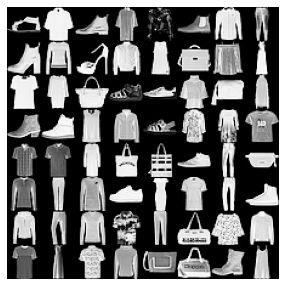

In [4]:
data,labels = next(iter(val_loader))
print(data.shape)
def show_data(data,ax=None):
    data = data.reshape(8,8,*data.shape[2:])
    montage = None
    for img in data:
        row = np.concatenate([im for im in img],axis=1)
        if montage is None:
            montage = row
        else:
            montage = np.concatenate([montage,row],axis=0)
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.imshow(montage,vmin=0,vmax=1,cmap='Greys_r')
    ax.axis('off')
show_data(data)

# Q Write a autoencoder model in the cell below.

In [5]:

class ConvAutoencoder(nn.Module):
    def __init__(self,latent_dim):
        super(ConvAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),  # b, 32, 28, 28
            nn.MaxPool2d(2, stride=2),  # b, 32, 14, 14
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),  # b, 32, 14, 14
            nn.MaxPool2d(2, stride=2),  # b, 1, 7, 7
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(32, 8, 3, stride=1, padding=0),  # b, 1, 5, 5
            nn.LeakyReLU(0.2,True),
            nn.Flatten(),
            nn.Linear(200,latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,200),
            nn.Unflatten(1,(2,10,10)),
            nn.ConvTranspose2d(2, 8, 3, stride=2,padding=0),  # b, 8, 7, 7
            nn.LeakyReLU(0.2,True),
            nn.ConvTranspose2d(8, 16, 5, stride=1, padding=0),  # b, 8, 15, 15
            nn.LeakyReLU(0.2,True),
            nn.ConvTranspose2d(16, 1, 4, stride=1, padding=0),  # b, 1, 28, 28
            nn.LeakyReLU(0.01,True),
        )
        
 

    def forward(self, x):
        enc_x = self.encoder(x)
        dec_x = self.decoder(enc_x)
      
        return   dec_x
    
      
# model = ConvAutoencoder2(40)
# print(model.encoder(data).shape)
# # print(model(data).shape) # this needs to be (batch size x 1 x 28 x 28) to match input


# Q Train your model on the training data
Use train_loader to provide training images and use MSELoss to optimize your model performance

In [6]:


loss_fn = nn.MSELoss() # note this is different loss function than for classification tasks
def train(model,optimizer,num_epochs=10):
    
    

    for epoch in range(num_epochs):
        model.train()
        for batch_idx,(images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # ===================forward=====================
            dec_images = model(images)
            loss = loss_fn(dec_images, images)
            # ===================backward====================
            
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss_avg = []
        with torch.no_grad():
            for batch_idx,(images, labels) in enumerate(val_loader):
                dec_images = model(images)
                val_loss = loss_fn(dec_images, images)
                val_loss_avg.append(val_loss.item())
            # ===================log========================
        val_loss_avg = np.mean(val_loss_avg)
        print(f"epoch [{epoch + 1} / {num_epochs}], loss:{loss.item():.4f}, val_loss:{val_loss_avg:.4f}")

        


In [12]:
torch.manual_seed(0)
np.random.seed(0)
model = ConvAutoencoder(10)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(model,optimizer,num_epochs =10)

epoch [1 / 10], loss:0.0533, val_loss:0.0529
epoch [2 / 10], loss:0.0317, val_loss:0.0349
epoch [3 / 10], loss:0.0292, val_loss:0.0307
epoch [4 / 10], loss:0.0283, val_loss:0.0286
epoch [5 / 10], loss:0.0258, val_loss:0.0274
epoch [6 / 10], loss:0.0244, val_loss:0.0258
epoch [7 / 10], loss:0.0256, val_loss:0.0251
epoch [8 / 10], loss:0.0227, val_loss:0.0242
epoch [9 / 10], loss:0.0243, val_loss:0.0235
epoch [10 / 10], loss:0.0234, val_loss:0.0231


# Q Display the input and reconstructed images for a batch of validation images

Text(0.5, 1.0, 'Reconstruction')

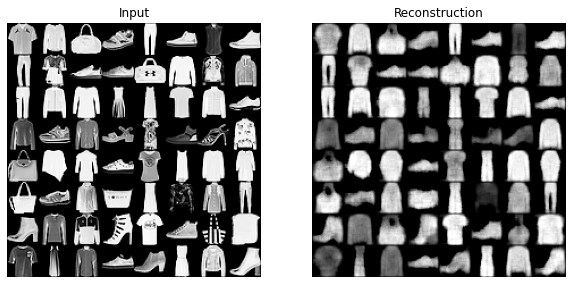

In [13]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
data,labels = next(iter(val_loader))
show_data(data,ax=axs[0])
axs[0].set_title('Input')
data_auto = model(data)
show_data(data_auto.detach().numpy(),ax=axs[1])
axs[1].set_title('Reconstruction')


# Q Calculate the loss function for each individual image of the validation dataset  the average and standard deviation of those losses 

 - Iterate over **val_loader** to get batches of validation image tensors.
 - Pass the image tensors through your model to get reconstructed images
 - iterate over each images and reconstruced image and obtain the loss for each individual pair e.g.

        for rec,img in zip(data_auto,data):
      
 - in each iteration append the loss to a list
 - calculate the mean and standard deviation of the losses
 

In [14]:
loss = []
for data,labels  in iter(val_loader):
    data_auto = model(data)
    for rec,img in zip(data_auto,data):
        loss.append(loss_fn(rec,img).item())
loss_avg = np.mean(loss)
loss_std = np.std(loss)

# Q run the anomaly test function to see how well your autoencoder performs

In [15]:

anomaly_test(model,loss_avg,loss_std)



total_real_anomolies = 100
anomalies detected = 60
fraction of anomalies detected = 0.49
false_positives = 11


# Q Display 64 input and reconstructed images from the test data

Text(0.5, 1.0, 'Reconstruction')

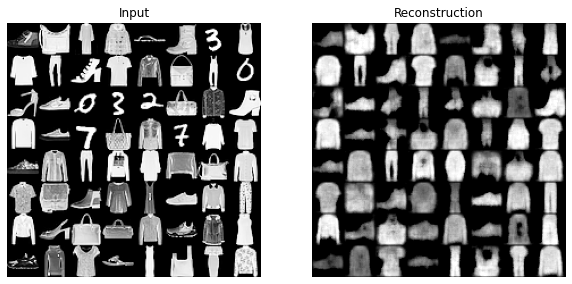

In [16]:
data = test_images[:64]
data_auto = model(data)

fig,axs = plt.subplots(1,2,figsize=(10,5))

show_data(data,ax=axs[0])
axs[0].set_title('Input')

show_data(data_auto.detach().numpy(),ax=axs[1])
axs[1].set_title('Reconstruction')


# How might you improve the anomaly detection capabilities of your model? 
What influence does changing the number of latent variables of your autoencoder have on the reconstruction quality for the validation data and the ability of the model to detect anomalies?


INSERT ANSWER HERE: 

# Excercise

Now lets put everything together to make a model on a new dataset - FashionMNIST.

This dataset is available as an example from the torchvision package.

Your task is to..

1) Get a training dataset and test dataset from datasets.FashionMNIST and build data loaders
 
2) To design a fully connected neural network using the ReLU activation function (except for the output nodes)
 
3) Optimize the model to fit the training data
 
4) Evaluate it's performance on the test data


Some required imports are given for you below...

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics


The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO (`full list here <https://pytorch.org/vision/stable/datasets.html>`_). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.




### Add the code to get the test dataset
The training_data dataset is made for you. 

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.

### insert code here
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### Pass the datasets to data loaders with a suitable batch size
Check the shape and dtype of the images and labels in the datasets

In [3]:
### insert code here

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

images, labels = next(iter(test_dataloader))
print("Shape of X [N, C, H, W]: ", images.shape, images.dtype)
print("Shape of y: ", labels.shape, labels.dtype)


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28]) torch.float32
Shape of y:  torch.Size([64]) torch.int64


### Define a fully connected neural network model 
First flatten the input and then use fully connected layers with some acquisition function to eventually give logits for each possible class. 



In [4]:
class NeuralNetwork(nn.Module):
### insert code here

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


### Now define a function to train the model
It should iterate over the training data loader to calculate the loss and optimise the model weights. Print the model loss every 100 batches.

In [5]:
def train(model,loss_fn,optimizer):
    ### insert code here
    size = len(train_dataloader.dataset)
    model.train()
    for batch, (images, labels) in enumerate(train_dataloader):
        

        # Compute prediction error
        pred = model(images)
        loss = loss_fn(pred, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Write a function to test your model
It should iterate through the test data loader and print the average loss and the percentage of correct predictions for the entire test dataset.

In [6]:
def test(model, loss_fn):
### insert code here
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            pred = model(images)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Optimise your model
First create a model instance and then define a loss function and an optimiser.


In [7]:
### insert code here
model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

The train and test your model for 5 epochs

In [8]:
### insert code here
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model,loss_fn,optimizer)
    test(model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.316721  [    0/60000]
loss: 0.585751  [ 6400/60000]
loss: 0.404803  [12800/60000]
loss: 0.509874  [19200/60000]
loss: 0.428297  [25600/60000]
loss: 0.421313  [32000/60000]
loss: 0.355760  [38400/60000]
loss: 0.531793  [44800/60000]
loss: 0.470454  [51200/60000]
loss: 0.499220  [57600/60000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.433765 

Epoch 2
-------------------------------
loss: 0.279265  [    0/60000]
loss: 0.349558  [ 6400/60000]
loss: 0.285124  [12800/60000]
loss: 0.400076  [19200/60000]
loss: 0.389500  [25600/60000]
loss: 0.397274  [32000/60000]
loss: 0.318266  [38400/60000]
loss: 0.507357  [44800/60000]
loss: 0.392762  [51200/60000]
loss: 0.440813  [57600/60000]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.402771 

Epoch 3
-------------------------------
loss: 0.235492  [    0/60000]
loss: 0.327434  [ 6400/60000]
loss: 0.233189  [12800/60000]
loss: 0.322507  [19200/60000]
loss: 0.361415  [25600/60000]
loss: 0.354643  [32000/600

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



This model can now be used to make predictions.



### Now display 16 images and the model predictions
- Get a batch of images and labels from the training dataset
- Get the model predicted labels for each image
- Make a 5x5 subplot and show the first 25 images
- Set the predicted and actual labels as the title of each axis



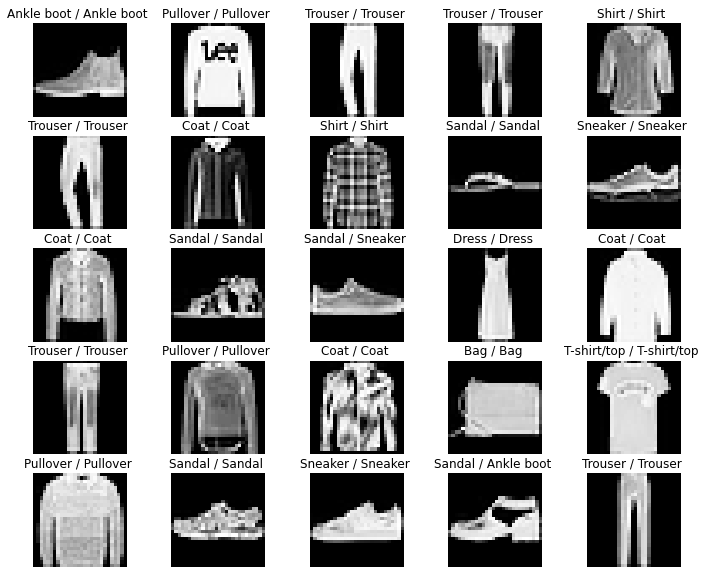

In [9]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

### insert code here
images,labels = next(iter(test_dataloader))
model.eval()
with torch.no_grad():
    output = model(images)
    pred = output.argmax(1)
    
fig,axs = plt.subplots(5,5,figsize=(12,10))
axs = axs.flatten()
for n,ax in enumerate(axs):
    ax.imshow(images[n][0],cmap="Greys_r")
    ax.set_title(f'{classes[pred[n]]} / {classes[labels[n]]} ')
    ax.axis('off')

### Display a confusion matrix for the test dataset
- iterate over the test dataset and get predictions for each image
- make arrays of real and predicted labels
- plot a confusion matrix, normalised according to the true labels and use the class labels for the axis display

In [10]:
test_acc = []
train_acc = []
# evaluate model:
model.eval()
test_loss = 0
correct = 0
pred_array = np.array([])
target_array = np.array([])
with torch.no_grad():
    for data, target in test_dataloader:
        output = model(data)
        pred = output.argmax(1)
        correct += pred.eq(target.data.view_as(pred)).sum()
        pred_array = np.append(pred_array,pred)
        target_array = np.append(target_array,target)
        
correct/len(test_dataloader.dataset)     

tensor(0.8724)

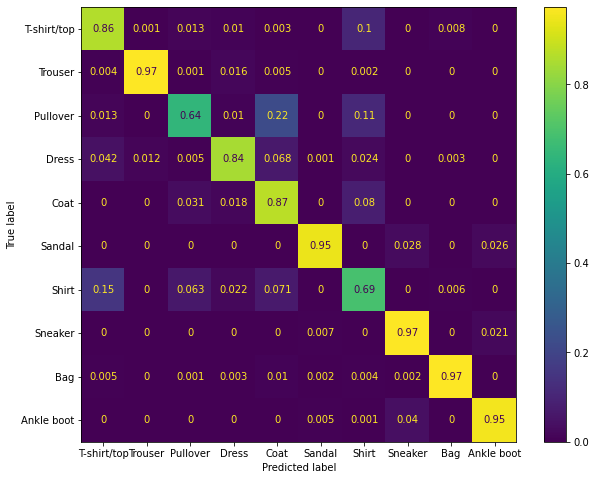

In [13]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(target_array, pred_array,
                                display_labels = classes, normalize='true')
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(10)

## Save the model for future use!

In [12]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchtext
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn
import torch.optim as optim

In [2]:
torch.manual_seed(99)
np.random.seed(99)

review_df = pd.read_csv("imdb_review_sentiment.tsv",sep='\t',header=0)
review_df = review_df.drop(['id'], axis=1)

train_df,test_df = train_test_split(review_df,test_size=0.2)
print(len(train_df))
print(len(test_df))
train_df.head()

20000
5000


,sentiment,review
16012,0,"I wouldn't normally write a comment on-line, b..."
9436,0,"<br /><br />I didn't see They Call Me Trinity,..."
5820,0,"First of all, I saw this movie when I was 7 ye..."
8625,0,"This movie was on t.v the other day, and I did..."
6658,1,I never fail to be amazed and horrified by the...


In [3]:
class CustomTextDataset(Dataset):
    def __init__(self, text, labels):
        self.labels = labels
        self.text = text
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.text[idx]
        
        return label, text

In [4]:


train_dataset = CustomTextDataset(train_df['review'].values,train_df['sentiment'].values)

train_dataset.__getitem__(0)


(0,
 'I wouldn\'t normally write a comment on-line, but this is the worst movie I\'ve ever seen. Not only that it\'s filmed just like a soap series (\\The young and the restless\\" is really filmed by professionals compared to this), but it also has awful cuts. It has no action. It is full of useless garbage.<br /><br />Here\'s an example: a guy wants to kill the main character as he got fired because of him. So (after loads of crap) here they are: the guy puts a knife at his throat and says something like \\"You\'re dead now\\". Then the main character says: \\"If you kill me you\'re dead. I\'ve told the police you\'re threatening me\\". So the (killer) guy goes like (just about to cry): \\"Oh no... the cops are following me!?!! Oh... my God\\".<br /><br />Remember: this is just an example. I really cannot believe this movie actually exists. So: IF you want to see the WORST movie ever... go ahead, I recommend it :)"')

# Write an algorithm to predict the sentiment of the review in the training dataset

First build the vocabulary from the training dataset

In [5]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for label, text in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
len(vocab)

101145

Then adapt the collate_batch function from the previous example to return a list of labels, text tokens and offsets and build dataloaders for the test and training datasets

In [6]:


def text_pipeline(x):
    return vocab(tokenizer(x))

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list, text_list, offsets

batch_size = 128


In [7]:
test_dataset = CustomTextDataset(test_df['review'].values,test_df['sentiment'].values)
train_loader = DataLoader(train_dataset, batch_size=64,shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)

Now build a text classification model. You might want to use a more advance fully connected model after the embedding

In [8]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Sequential(
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(True),
            nn.Linear(embed_dim, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(True),
            nn.Linear(200, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(True),
            nn.Linear(200, num_class),
            )
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
#         self.fc.weight.data.uniform_(-initrange, initrange)
#         self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        x = self.embedding(text,offsets)
        out = self.fc(x)
        return out

Instantiate your model and define a loss function and an optimiser

In [9]:
num_class = 2
vocab_size = len(vocab)
emsize = 64

model = TextClassificationModel(vocab_size, emsize, num_class)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

Now finally train your model! You might need to use multiple batches

In [10]:
def train(model,loss_fn,optimizer):
    size = len(train_loader.dataset)
    model.train()
    for batch, (labels, text, offsets) in enumerate(train_loader):
        
        # Compute prediction error
        pred = model(text, offsets)
        loss = loss_fn(pred, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(labels)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(model, loss_fn):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (labels, text, offsets) in test_loader:
            pred = model(text, offsets)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
for epoch in range(10):
    train(model,criterion,optimizer)
    test(model,criterion)

loss: 0.699064  [    0/20000]
loss: 0.555151  [ 6400/20000]
loss: 0.611116  [12800/20000]
loss: 0.578686  [19200/20000]
Test Error: 
 Accuracy: 75.5%, Avg loss: 0.504558 

loss: 0.394271  [    0/20000]
loss: 0.323179  [ 6400/20000]
loss: 0.487102  [12800/20000]
loss: 0.447434  [19200/20000]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.467434 

loss: 0.313329  [    0/20000]
loss: 0.258556  [ 6400/20000]
loss: 0.403295  [12800/20000]
loss: 0.361787  [19200/20000]
Test Error: 
 Accuracy: 80.2%, Avg loss: 0.456631 

loss: 0.263407  [    0/20000]
loss: 0.198248  [ 6400/20000]
loss: 0.336493  [12800/20000]
loss: 0.308183  [19200/20000]
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.461753 

loss: 0.213277  [    0/20000]
loss: 0.142495  [ 6400/20000]
loss: 0.282449  [12800/20000]
loss: 0.270808  [19200/20000]
Test Error: 
 Accuracy: 81.5%, Avg loss: 0.487720 

loss: 0.186789  [    0/20000]
loss: 0.092714  [ 6400/20000]
loss: 0.248733  [12800/20000]
loss: 0.211119  [19200/20000]
Test Error: 
 Accura